In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
import numpy as np
from scipy.spatial import distance

In [2]:
dfAbnormal1 = pd.read_csv("../cleanData/clean_abnormal1.csv")
dfnormal1 = pd.read_csv("../cleanData/clean_normal.csv")
dfAbnormal = pd.read_csv("../cleanData/clean_abnormal1.csv")
dfnormal = pd.read_csv("../cleanData/clean_normal.csv")


dfAbnormal_1 = pd.concat([dfAbnormal, dfAbnormal1], ignore_index=True)
dfnormal_1 = pd.concat([dfnormal, dfnormal1], ignore_index=True)

In [9]:
dfAbnormal_1['Label'] = 1
dfnormal_1['Label'] = 0
df_combined = pd.concat([dfAbnormal_1, dfnormal_1], ignore_index=True)



X = df_combined.drop(columns=['Label'])  # Features
y = df_combined['Label']  # Labels
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X_train, y_train)
feature_weights = model.coef_


# 获取前五大特征权重的索引
top_five_indices = np.argsort(np.abs(feature_weights))[0][-5:]

# 获取对应的特征名字
top_five_features = X.columns[top_five_indices]

# 选择重要特征的数据集
X_train_selected = X_train[:, top_five_indices]
X_test_selected = X_test[:, top_five_indices]


c:\Users\Lab\AppData\Local\anaconda3\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


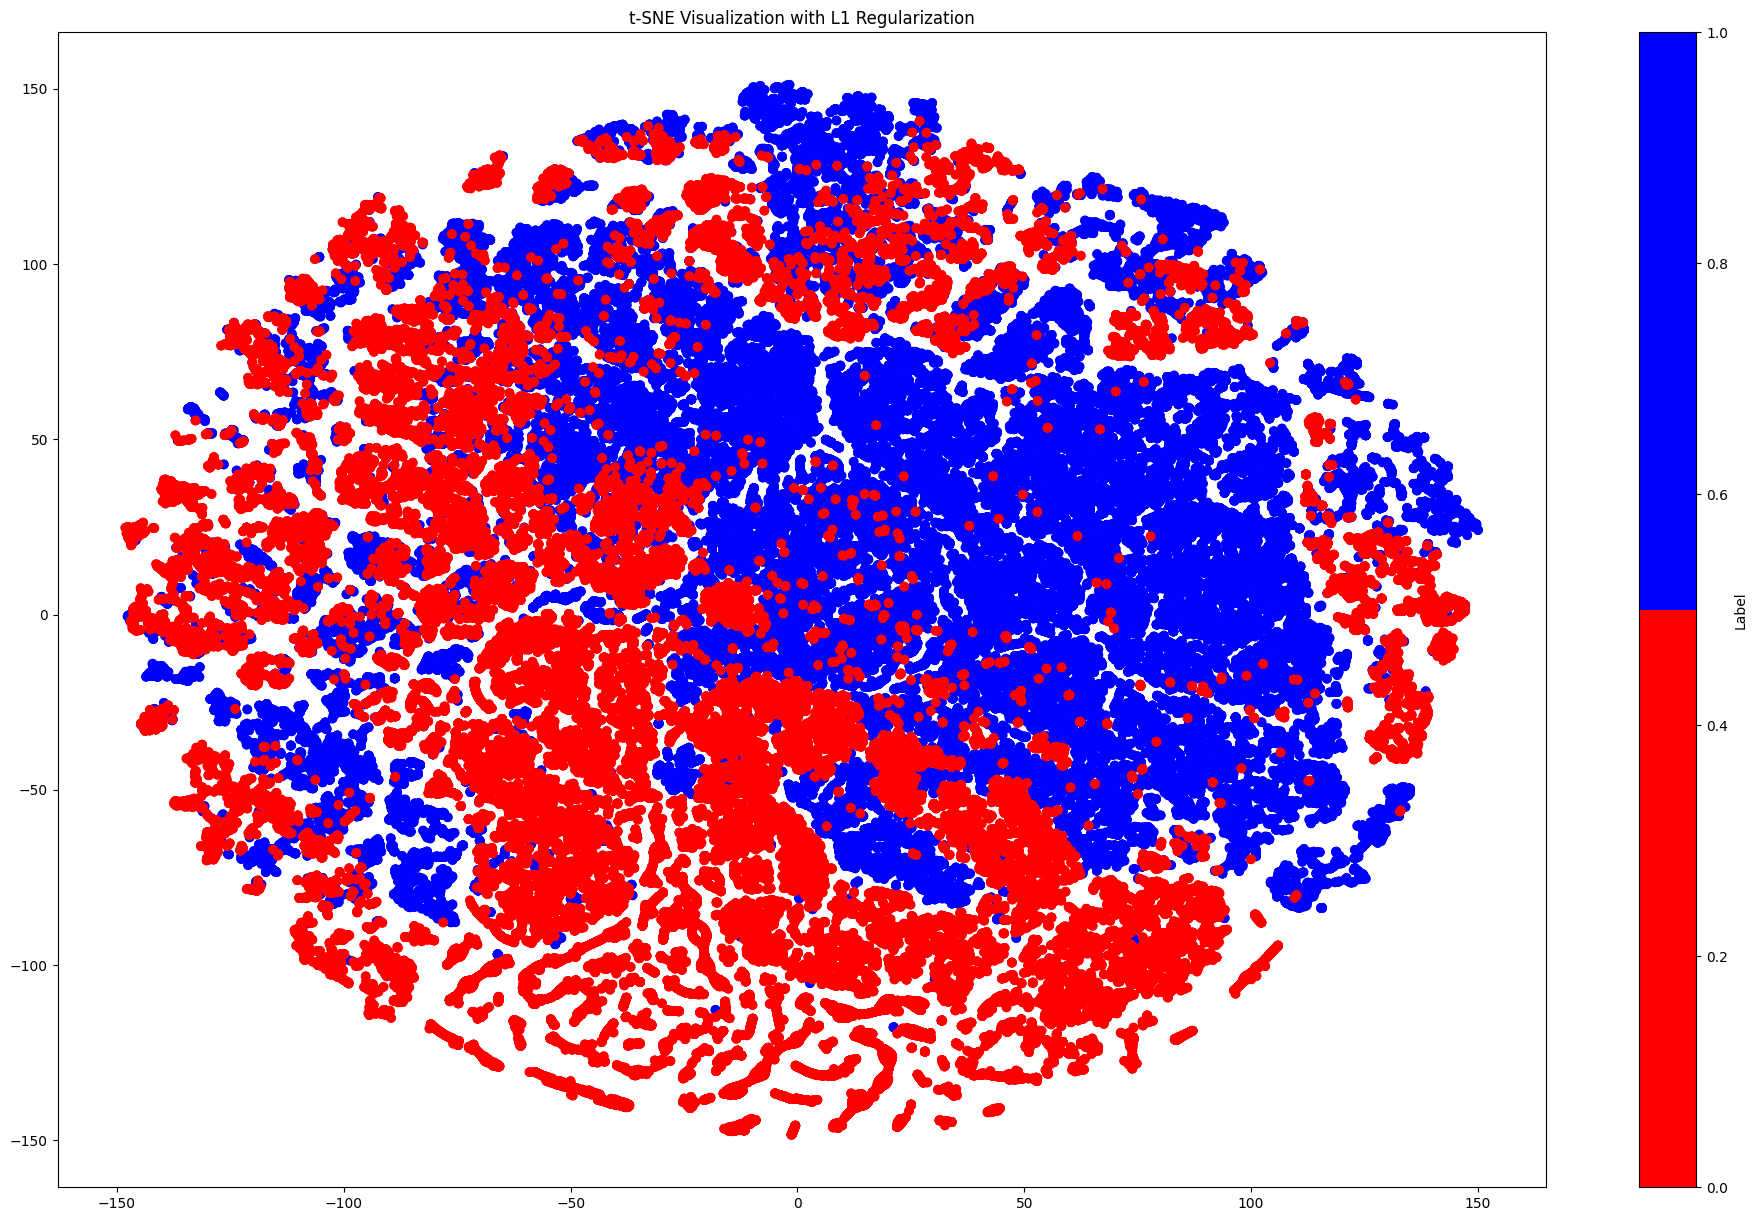

In [10]:
# 應用 t-SNE 進行可視化
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# 創建新的 DataFrame 以保存 t-SNE 結果
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Label'] = y
# 可視化 t-SNE 結果
plt.figure(figsize=(24, 15))
scatter = plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=df_tsne['Label'], cmap=ListedColormap(['red', 'blue']))
plt.title('t-SNE Visualization with L1 Regularization')
plt.colorbar(scatter, label='Label')
plt.show()

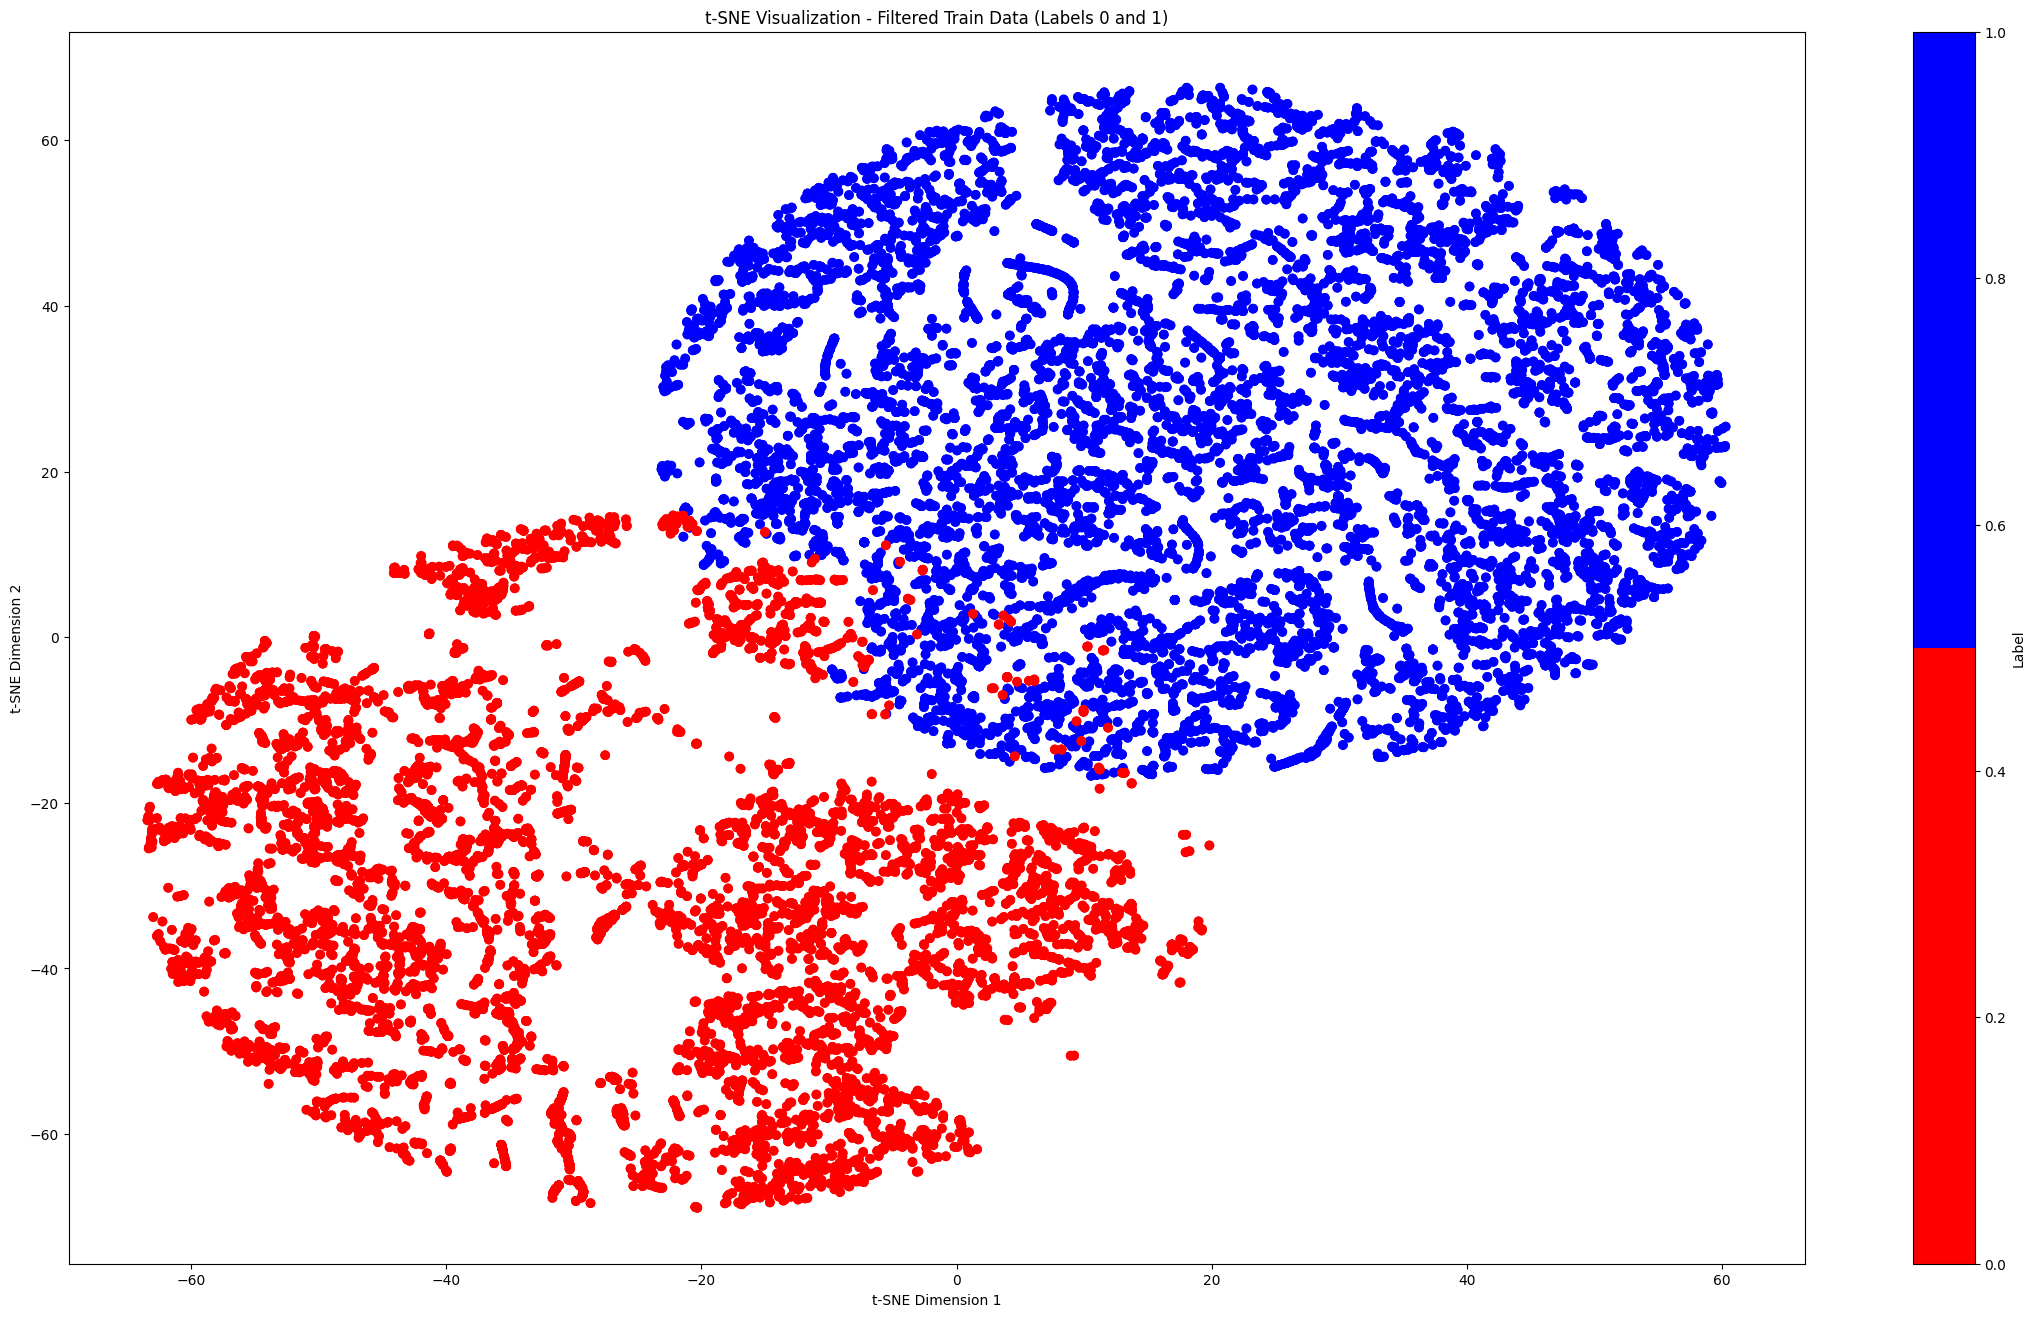

In [16]:
# 创建一个新的DataFrame包含t-SNE结果
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Label'] = df_combined['Label']

# 将数据分为训练和测试集 (这里需要您具体的训练和测试集划分逻辑)
train_tsne_embedded = df_tsne[['TSNE1', 'TSNE2']].values  # 替换为实际的训练集嵌入结果
train_labels = df_tsne['Label'].values  # 替换为实际的训练集标签
# 计算类别的中心点
def compute_class_centers(points, labels):
    unique_labels = np.unique(labels)
    centers = {}
    for label in unique_labels:
        centers[label] = np.mean(points[labels == label], axis=0)
    return centers

# 定义阈值来过滤数据
distance_threshold = 42  # 这是一个示例阈值，请根据实际情况调整

# 筛选标签为0和1的训练数据点
train_mask = np.isin(train_labels, [0, 1])
train_tsne_embedded_01 = train_tsne_embedded[train_mask]
train_labels_01 = train_labels[train_mask]

# 计算训练数据的类别中心
train_class_centers = compute_class_centers(train_tsne_embedded_01, train_labels_01)

# 过滤训练数据
filtered_train_points = []
filtered_train_labels = []
for i, point in enumerate(train_tsne_embedded_01):
    label = train_labels_01[i]
    center = train_class_centers[label]
    if distance.euclidean(point, center) < distance_threshold:
        filtered_train_points.append(point)
        filtered_train_labels.append(label)

filtered_train_points = np.array(filtered_train_points)


# 可视化过滤后的训练数据
plt.figure(figsize=(28, 16))
plt.scatter(filtered_train_points[:, 0], filtered_train_points[:, 1], c=filtered_train_labels, cmap=ListedColormap(['red', 'blue']))
plt.title('t-SNE Visualization - Filtered Train Data (Labels 0 and 1)')
plt.colorbar(label='Label')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [38]:
# 创建一个哈希表，以加快查找速度
point_to_index = {tuple(point): index for index, point in enumerate(train_tsne_embedded)}

# 使用哈希表查找每个点的索引
indices = np.array([point_to_index[tuple(point)] for point in filtered_train_points])

selected_rows = df_combined.iloc[indices]

finalFeuture = top_five_features.copy()

finalFeuture = list(finalFeuture)

finalFeuture.append("Label")

df_final = pd.DataFrame(selected_rows)

df_final = df_final.loc[:, finalFeuture]

In [39]:
df_final

,CONDUCTIVITY,BREATH,PULSE,MIN_BLOOD,MAX_BLOOD,Label
56647,14.1,15.852175,77.0,72.0,188.0,1
56649,14.2,15.852175,84.0,66.0,127.0,1
56650,14.2,15.852175,84.0,66.0,127.0,1
56651,14.2,15.852175,84.0,66.0,127.0,1
56653,14.2,15.852175,83.0,59.0,139.0,1
...,...,...,...,...,...,...
207663,14.1,15.482281,63.0,63.0,157.0,0
207664,14.1,15.482281,63.0,63.0,157.0,0
207665,14.1,15.482281,63.0,63.0,157.0,0
207666,14.1,15.482281,63.0,63.0,157.0,0


In [43]:
df_final.to_csv("Logistic.csv")